In [1]:
#get rid of annoying GPU warnings (and others)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.models import Sequential, model_from_json  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def load_image_files(container_path, dimension=(128,128)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Your own dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            if file.suffix.lower() not in ['.jpg', '.jpeg', '.png','.webp','.gif']:
                print(f"Skipped non-image file: {file}")
                continue
            img = cv2.imread(str(file), cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {file}")
                continue
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB format
            img_resized = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
            
            if img_resized.size == 0:
                print(f"Empty image: {file}")
                continue
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

   # Perform data augmentation
    # augmented_data_bunch = augment_images(images, target)

    # Return both the original and augmented data
    return Bunch(
        data=flat_data,
        target=target,
        target_names=categories,
        images=images,
        DESCR=descr
    )

# **Data Aquision**

In [4]:
image_dataset = load_image_files("/kaggle/input/soil-data-v3/Soil_Data_V3/Trains")
image_dataset_test = load_image_files("/kaggle/input/soil-data-v3/Soil_Data_V3/Tests")

Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Mary/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Sand/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Trains/Silt/desktop.ini
Skipped non-image file: /kaggle/input/soil-data-v3/Soil_Data_V3/Tests/Chalky/desktop.ini


In [5]:
accuracy = []
f1_score = []
precision_score = []
recall_score = []

In [6]:
X_train = image_dataset.images.reshape(-1,128*128*3)
X_test = image_dataset_test.images.reshape(-1,128*128*3)
y_train = image_dataset.target
y_test=image_dataset_test.target

# ** Feature Reduction:LDA**

In [7]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess test dataset

test_features = X_test


# Load and preprocess train dataset

train_features = X_train


# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

# Perform PCA
pca = PCA(n_components = 200)
X_train = pca.fit_transform(scaled_train_features, y_train)
X_test = pca.transform(scaled_test_features)

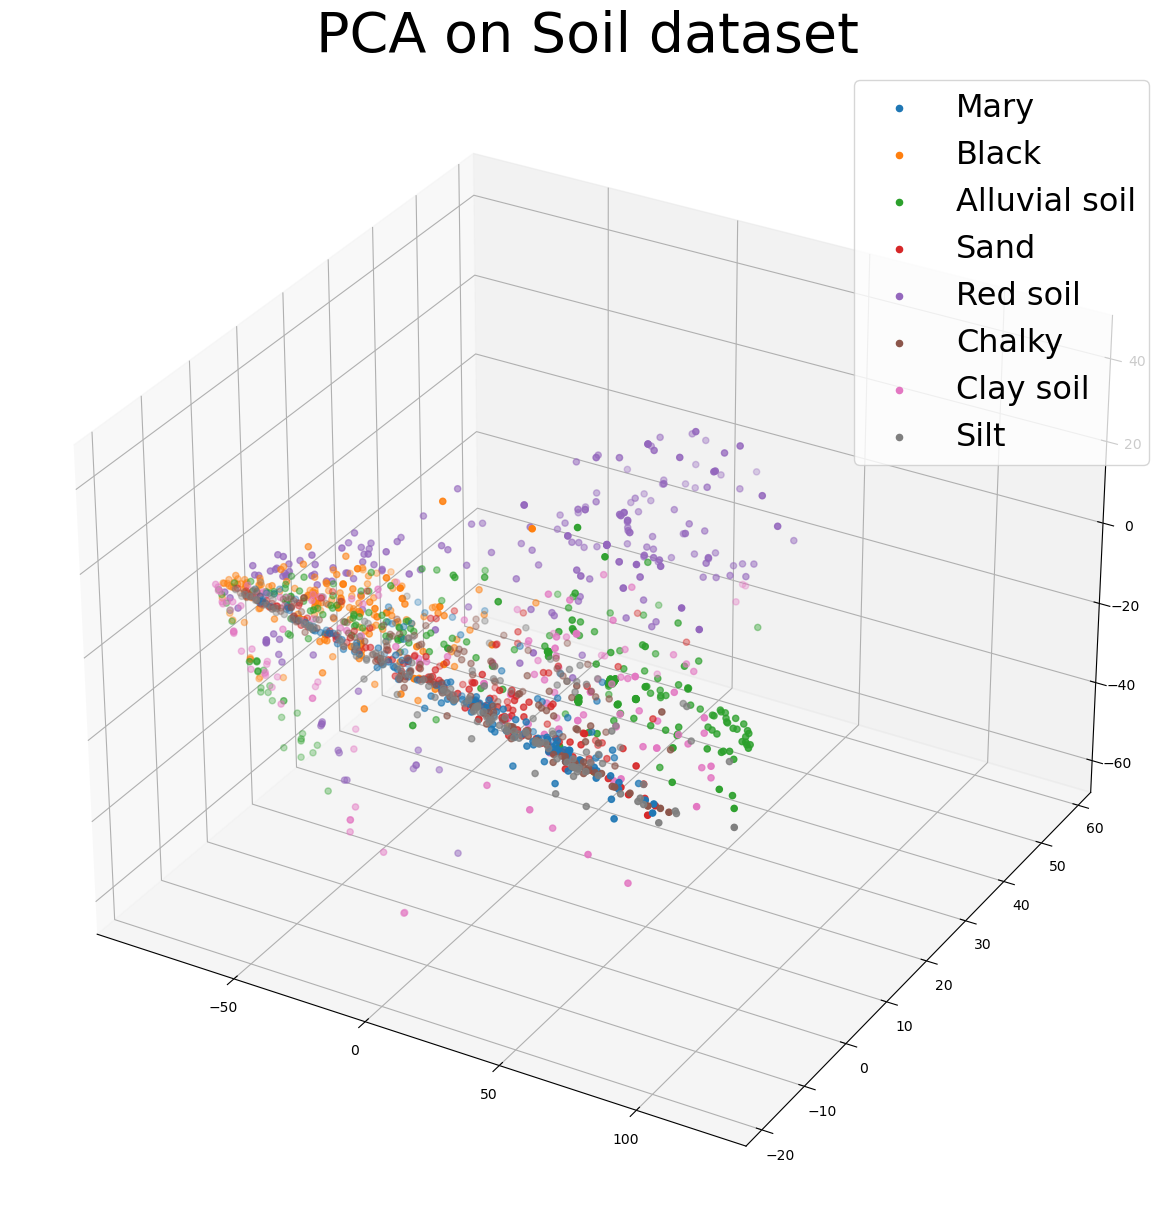

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

for i, target_name in zip([0, 1, 2, 3, 4, 5, 6, 7], image_dataset.target_names):
    ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], zs=X_test[y_test == i, 2], label=target_name)

ax.legend(fontsize=23)
ax.set_title('PCA on Soil dataset', fontsize=40)

plt.show()


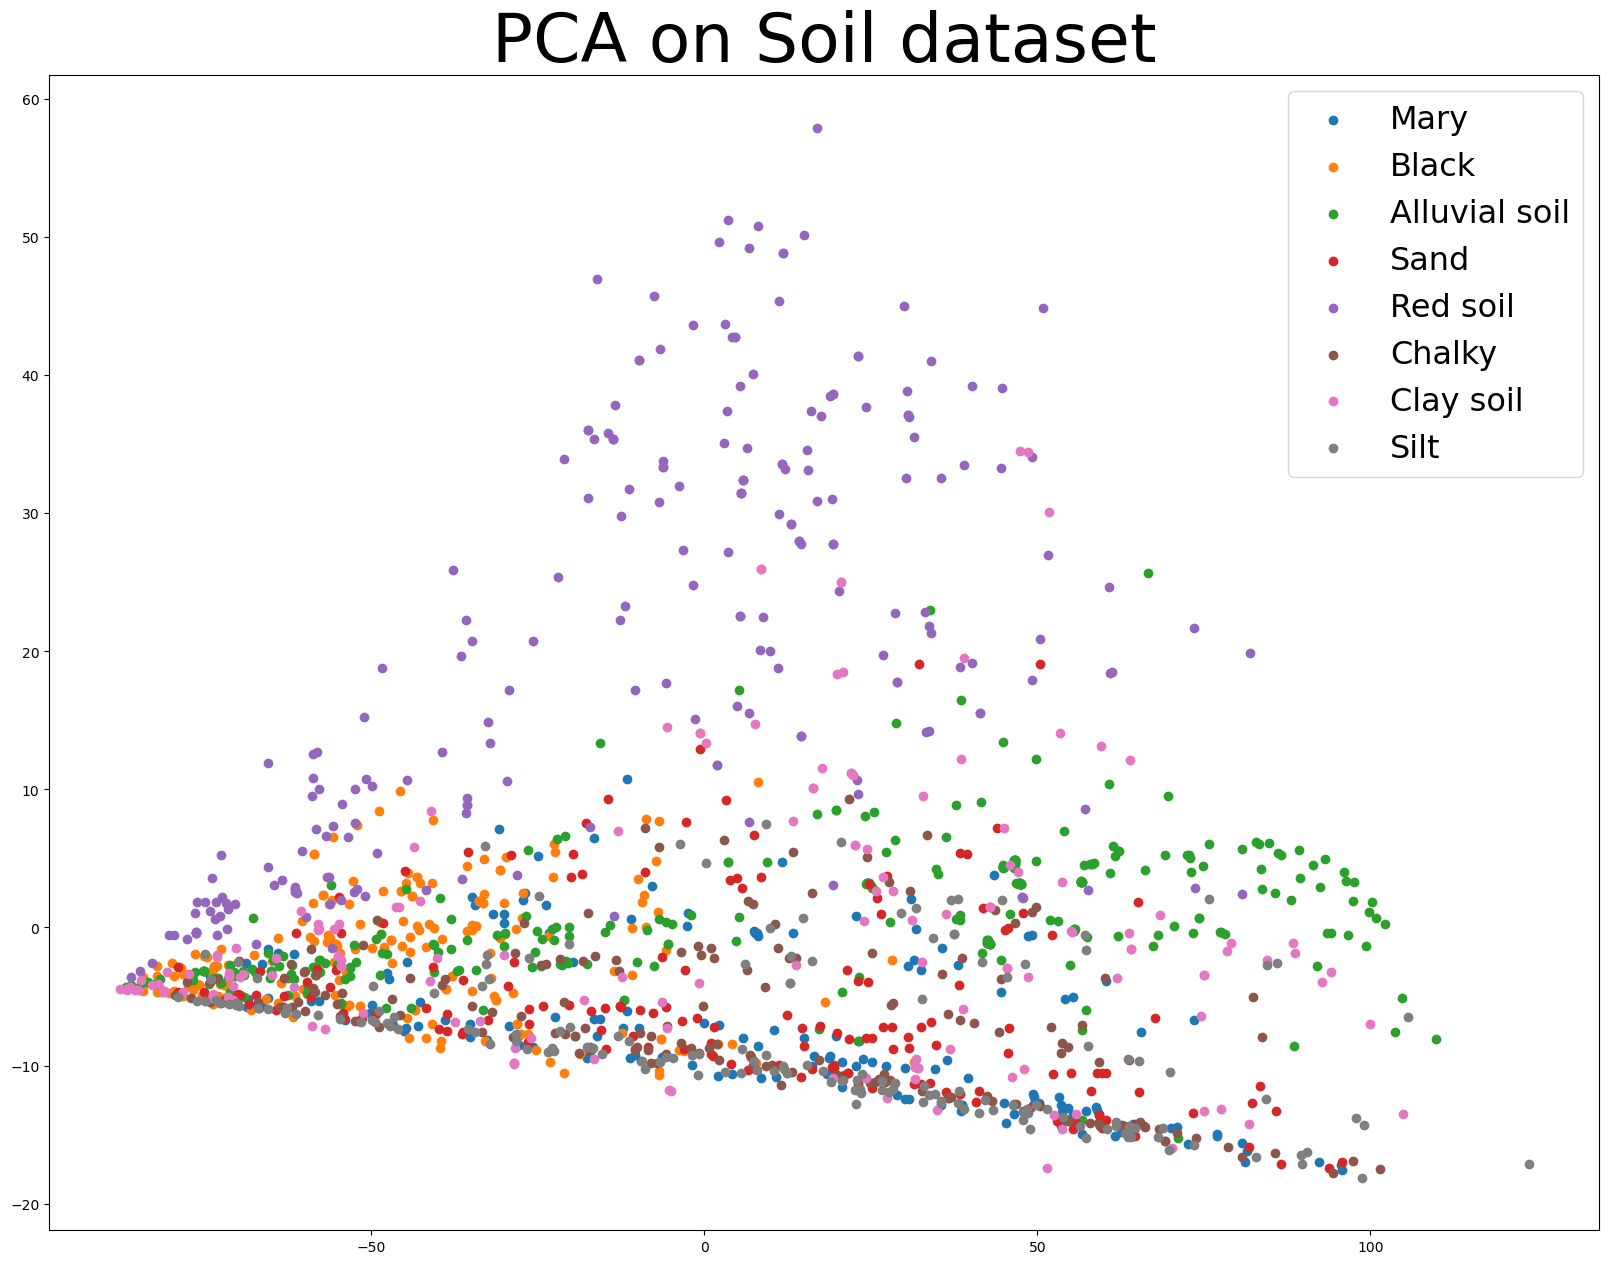

In [9]:
plt.figure(figsize=(20,15))
for  i, target_name in zip([ 0, 1, 2, 3, 4, 5, 6, 7], image_dataset.target_names):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test== i, 1], label=target_name)
plt.legend(fontsize=23)
plt.title('PCA on Soil dataset', fontsize =49)

plt.show()

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3670, 200)
(1584, 200)
(3670,)
(1584,)


In [11]:
image_dataset.target_names

['Mary',
 'Black',
 'Alluvial soil',
 'Sand',
 'Red soil',
 'Chalky',
 'Clay soil',
 'Silt']

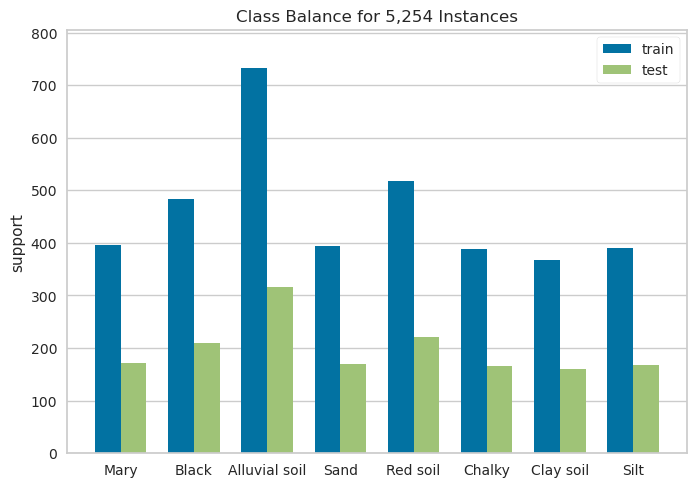

<Axes: title={'center': 'Class Balance for 5,254 Instances'}, ylabel='support'>

In [12]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=image_dataset.target_names, ylabel='Samples')
visualizer.fit(y_train, y_test)
visualizer.show()

In [13]:
from sklearn.utils import class_weight

sample_weights = class_weight.compute_sample_weight(class_weight = 'balanced', 
                                                  y = y_train)

# Random Forrest Tree

In [15]:
from sklearn.ensemble import RandomForestClassifier
import time

# Start timing
start_time = time.time()
clf_rf = RandomForestClassifier(class_weight='balanced')

params_dt = {'min_samples_split':[2, 3, 5, 7, 9], 
            'min_samples_leaf': [1, 2, 3, 5, 7, 9],
            'max_depth': [1, 3, 5, 7, 9]}

clf_rf = GridSearchCV(clf_rf, params_dt, cv=10, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = metrics.precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = metrics.recall_score(y_test, y_pred_rf, average='weighted')
print(metrics.classification_report(y_test, y_pred_rf, target_names=image_dataset.target_names))
print("Accuracy", round(accuracy_rf*100,2))
print("F1-score ",round(f1_rf*100,2))
print("Precision ",round(precision_rf*100,2))
print("Recall",round(recall_rf*100,2))

accuracy.append(round(accuracy_rf*100,2))
f1_score.append(round(f1_rf*100,2))

print(clf_rf.best_score_)
print(clf_rf.best_params_)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


               precision    recall  f1-score   support

         Mary       0.91      0.77      0.84       172
        Black       0.50      0.96      0.65       210
Alluvial soil       0.92      0.82      0.87       316
         Sand       0.82      0.55      0.66       170
     Red soil       0.88      0.86      0.87       222
       Chalky       0.67      0.69      0.68       166
    Clay soil       0.86      0.59      0.70       160
         Silt       0.71      0.60      0.65       168

     accuracy                           0.75      1584
    macro avg       0.78      0.73      0.74      1584
 weighted avg       0.79      0.75      0.75      1584

Accuracy 74.81
F1-score  75.3
Precision  79.21
Recall 74.81
0.8362397820163487
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}
Elapsed Time: 1071.48 seconds


In [16]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
clf_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

params_dt = {'min_samples_split':[2, 3, 5, 7, 9], 
            'min_samples_leaf': [1, 2, 3, 5,7,9],
            'max_depth': [1, 3, 5, 7,9]}

clf_dt = GridSearchCV(clf_dt, params_dt, cv=10, n_jobs=-1)
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)
accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt)
f1_dt = metrics.f1_score(y_test, y_pred_dt, average='weighted')
precision_dt = metrics.precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = metrics.recall_score(y_test, y_pred_dt, average='weighted')
print(metrics.classification_report(y_test, y_pred_dt, target_names=image_dataset.target_names))
print("Accuracy", round(accuracy_dt*100,2))

print("F1-score ",round(f1_dt*100,2))
print("Precision ",round(precision_dt*100,2))
print("Recall",round(recall_dt*100,2))

accuracy.append(round(accuracy_dt*100,2))
f1_score.append(round(f1_dt*100,2))

print(clf_dt.best_score_)
print(clf_dt.best_params_)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

               precision    recall  f1-score   support

         Mary       0.68      0.45      0.54       172
        Black       0.62      0.65      0.63       210
Alluvial soil       0.86      0.73      0.79       316
         Sand       0.39      0.26      0.31       170
     Red soil       0.90      0.85      0.87       222
       Chalky       0.35      0.45      0.39       166
    Clay soil       0.57      0.52      0.54       160
         Silt       0.32      0.59      0.42       168

     accuracy                           0.59      1584
    macro avg       0.59      0.56      0.56      1584
 weighted avg       0.62      0.59      0.60      1584

Accuracy 58.78
F1-score  59.62
Precision  62.5
Recall 58.78
0.646866485013624
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}
Elapsed Time: 214.51 seconds


# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
kn = KNeighborsClassifier(n_neighbors=7)
kn.fit(X_train,y_train)

kn_pred = kn.predict(X_test)
print("----------------------------------")
print(metrics.classification_report(y_pred=kn_pred,y_true=y_test, target_names=image_dataset.target_names))
print("----------------------------------")
print("Accuracy = ", round(metrics.accuracy_score(kn_pred, y_test) *100,2))
print("----------------------------------")
print("F1-score = ", round(metrics.f1_score(kn_pred,y_test, average='weighted') * 100,2))

accuracy.append(round(metrics.accuracy_score(kn_pred, y_test) *100,2))
f1_score.append( round(metrics.f1_score(kn_pred,y_test, average='weighted') * 100,2))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

----------------------------------
               precision    recall  f1-score   support

         Mary       0.66      0.45      0.54       172
        Black       0.57      0.79      0.66       210
Alluvial soil       0.46      0.88      0.61       316
         Sand       0.45      0.38      0.41       170
     Red soil       0.89      0.84      0.87       222
       Chalky       0.37      0.25      0.30       166
    Clay soil       0.78      0.26      0.39       160
         Silt       0.80      0.23      0.36       168

     accuracy                           0.57      1584
    macro avg       0.62      0.51      0.52      1584
 weighted avg       0.61      0.57      0.54      1584

----------------------------------
Accuracy =  56.63
----------------------------------
F1-score =  59.1
Elapsed Time: 0.4 seconds


[Text(0, 0.5, 'Mary'),
 Text(0, 1.5, 'Black'),
 Text(0, 2.5, 'Alluvial soil'),
 Text(0, 3.5, 'Sand'),
 Text(0, 4.5, 'Red soil'),
 Text(0, 5.5, 'Chalky'),
 Text(0, 6.5, 'Clay soil'),
 Text(0, 7.5, 'Silt')]

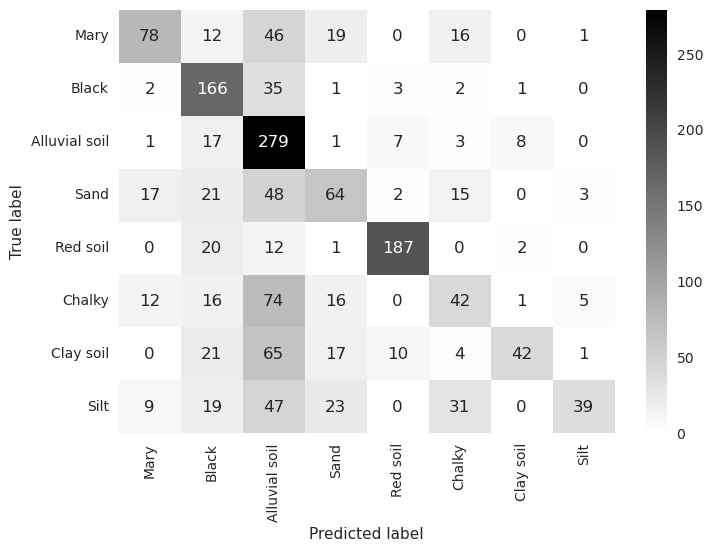

In [18]:
import seaborn as sns
cm = metrics.confusion_matrix(y_test, kn_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='binary')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(image_dataset.target_names, rotation='vertical')
ax.yaxis.set_ticklabels(image_dataset.target_names, rotation='horizontal')

# SVM

In [19]:
# set paremeters
param_grid = {'C': [0.01, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'poly', 'sigmoid','linear']}

scores = ['recall', 'precision',]

In [21]:
import time
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=10,
                       scoring='%s_weighted' % score)   
    start_time = time.time()
    grid.fit(X_train, y_train) 

    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()
    print("Best parameters set found on development set:")
    print(grid.best_params_)
    print()

    print("Detailed classification report:")
    print()
    
    y_pred = grid.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    print("Accuracy",metrics.accuracy_score(y_test, y_pred))
    print("Precison",metrics.precision_score(y_test, y_pred, average='weighted'))
    print("F1-Score",metrics.f1_score(y_test, y_pred, average='weighted'))
    print(metrics.classification_report(y_test, y_pred, target_names=image_dataset.target_names))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed Time:", round(elapsed_time, 2), "seconds")

accuracy.append(round(metrics.accuracy_score(y_test, y_pred) *100,2))
f1_score.append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100,2))

# Tuning hyper-parameters for recall


Grid scores on development set:

0.267 (+/-0.046) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.288 (+/-0.054) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.274 (+/-0.055) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.868 (+/-0.030) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
0.132 (+/-0.102) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
0.865 (+/-0.052) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
0.269 (+/-0.020) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.868 (+/-0.030) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}
0.726 (+/-0.057) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.638 (+/-0.056) for {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.278 (+/-0.041) for {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.930 (+/-0.034) for {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.749 (+/-0.048) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.838 (+/-0.057) for {'C': 1, 'gamma': '

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning


Grid scores on development set:

0.208 (+/-0.055) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.446 (+/-0.086) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.207 (+/-0.056) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.886 (+/-0.027) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
0.027 (+/-0.064) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
0.871 (+/-0.050) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
0.259 (+/-0.086) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.886 (+/-0.027) for {'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}
0.800 (+/-0.042) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.770 (+/-0.037) for {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.443 (+/-0.141) for {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.932 (+/-0.034) for {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.812 (+/-0.032) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.841 (+/-0.057) for {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.287 (+/-0.1

# Confusion Matrix

[Text(0, 0.5, 'Mary'),
 Text(0, 1.5, 'Black'),
 Text(0, 2.5, 'Alluvial soil'),
 Text(0, 3.5, 'Sand'),
 Text(0, 4.5, 'Red soil'),
 Text(0, 5.5, 'Chalky'),
 Text(0, 6.5, 'Clay soil'),
 Text(0, 7.5, 'Silt')]

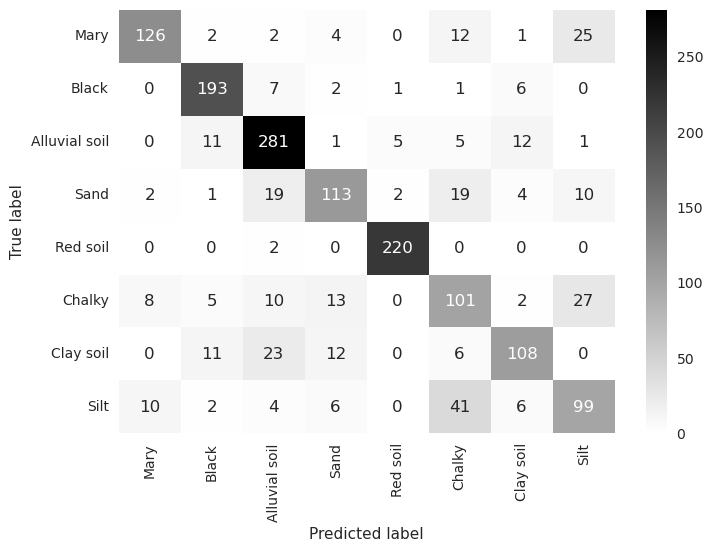

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt    


from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='binary')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(image_dataset.target_names, rotation='vertical')
ax.yaxis.set_ticklabels(image_dataset.target_names, rotation='horizontal')

# CNN

In [23]:
X_train= image_dataset.images
X_test= image_dataset_test.images
y_train= image_dataset.target
y_test=image_dataset_test.target

print(X_train.shape)
print(X_test.shape) 


(3670, 128, 128, 3)
(1584, 128, 128, 3)


In [24]:
#Trial
from keras.models import Sequential

from keras.layers import Conv2D, AveragePooling2D,Activation,Dropout, Flatten, BatchNormalization, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128,128,3))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))    

model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))


model.add(Conv2D(64,(3, 3))) 
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))   
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))
          
model.add(Conv2D(128,(3, 3))) 
model.add(Conv2D(128,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))  
model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector
model.add(Dropout(0.2)) 


# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation
model.add(Dropout(0.2))

model.add(Dense(8))                                 # final 10 FCN nodes
model.add(Activation('softmax'))  

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 average_pooling2d (AverageP  (None, 63, 63, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 32)       128       
 hNormalization)                                                 
                                                        

In [27]:
# we'll use the same optimizer

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)

In [29]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [30]:
cvscores = []
for train, test in kfold.split(X_train, y_train):
    history=model.fit(X_train, y_train, batch_size=8, epochs=80, validation_data=(X_test,y_test),
          verbose=1, callbacks=[earlystopping])
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/80
459/459 [==============================] - 26s 17ms/step - loss: 1.6886 - accuracy: 0.4054 - val_loss: 1.5424 - val_accuracy: 0.4558
Epoch 2/80
459/459 [==============================] - 7s 15ms/step - loss: 1.3176 - accuracy: 0.5450 - val_loss: 1.7785 - val_accuracy: 0.4470
Epoch 3/80
459/459 [==============================] - 7s 15ms/step - loss: 0.9430 - accuracy: 0.6899 - val_loss: 0.8802 - val_accuracy: 0.7109
Epoch 4/80
459/459 [==============================] - 7s 15ms/step - loss: 0.5881 - accuracy: 0.8120 - val_loss: 0.7197 - val_accuracy: 0.7746
Epoch 5/80
459/459 [==============================] - 7s 15ms/step - loss: 0.4273 - accuracy: 0.8662 - val_loss: 0.8861 - val_accuracy: 0.7771
Epoch 6/80
459/459 [==============================] - 7s 15ms/step - loss: 0.3304 - accuracy: 0.8978 - val_loss: 0.7091 - val_accuracy: 0.8144
Epoch 7/80
459/459 [==============================] - 7s 15ms/step - loss: 0.2844 - accuracy: 0.9106 - val_loss: 0.6426 - val_accuracy: 0.847

Training

**Testing**

In [31]:
score = model.evaluate(X_test, y_test)                   
print('Test score:', score[0])
print('Test accuracy:', round(score[1]*100,2))


50/50 [==============================] - 1s 14ms/step - loss: 0.7946 - accuracy: 0.8763
Test score: 0.7946290373802185
Test accuracy: 87.63


In [32]:
y_pred = model.predict(X_test)
# Get the class predictions (indices of the highest probability) from y_pred
y_pred = np.argmax(y_pred, axis=1)

# y_test, y_pred = np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=1) #magical fix
print(metrics.classification_report(y_test, y_pred, target_names=image_dataset.target_names))
accuracy_cnn = metrics.accuracy_score(y_test, y_pred)
f1_cnn = metrics.f1_score(y_test, y_pred, average='weighted')
precision_cnn = metrics.precision_score(y_test, y_pred, average='weighted')
recall_cnn = metrics.recall_score(y_test, y_pred, average='weighted')
print("Accuracy", accuracy_cnn * 100)
print("F1-Score", f1_cnn * 100)
accuracy.append(accuracy_cnn * 100)
f1_score.append(f1_cnn * 100)
precision_score.append(precision_cnn * 100)
recall_score.append(recall_cnn * 100)

50/50 [==============================] - 1s 9ms/step
               precision    recall  f1-score   support

         Mary       0.86      0.94      0.90       172
        Black       0.86      0.96      0.90       210
Alluvial soil       0.91      0.93      0.92       316
         Sand       0.83      0.76      0.80       170
     Red soil       0.96      0.98      0.97       222
       Chalky       0.78      0.81      0.79       166
    Clay soil       0.86      0.83      0.84       160
         Silt       0.90      0.70      0.79       168

     accuracy                           0.88      1584
    macro avg       0.87      0.86      0.86      1584
 weighted avg       0.88      0.88      0.87      1584

Accuracy 87.62626262626263
F1-Score 87.44360295073506


[Text(0, 0.5, 'Mary'),
 Text(0, 1.5, 'Black'),
 Text(0, 2.5, 'Alluvial soil'),
 Text(0, 3.5, 'Sand'),
 Text(0, 4.5, 'Red soil'),
 Text(0, 5.5, 'Chalky'),
 Text(0, 6.5, 'Clay soil'),
 Text(0, 7.5, 'Silt')]

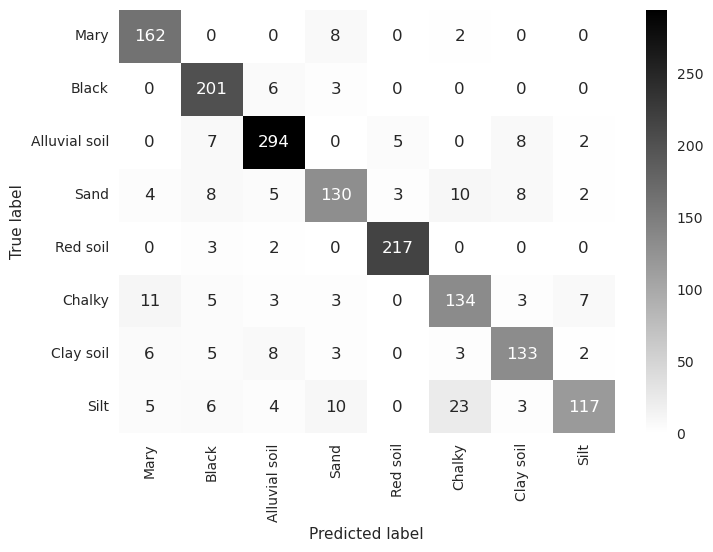

In [33]:
import seaborn as sns
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='binary')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(image_dataset.target_names, rotation='vertical')
ax.yaxis.set_ticklabels(image_dataset.target_names, rotation='horizontal')

# EDA

In [34]:
# plot history in terms of accuracy per epoch
plt.style.use("ggplot")
plt.figure(figsize=(20,15))
# plt.plot( H.history["loss"], label = ["train_loss"])
# plt.plot( H.history["val_loss"], label = ["val_loss"])
plt.plot( history.history["accuracy"], label = "Training accuracy", color='green', linewidth=4)
plt.plot( history.history["val_accuracy"], label = "Validation accuracy", color='red', linewidth=4)

# plt.title("Training loss and Accuracy")
plt.ylim((0,1))
plt.xlabel("Epochs", fontsize=35)
plt.ylabel("Accuracy", fontsize=35)
# plt.legend()
plt.legend(fontsize=35)
plt.tick_params(labelsize=35)
# plt.savefig("pruned_VGGNet_with_cropping.png")

NameError: name 'history' is not defined

<Figure size 2000x1500 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(20, 10))
data = [accuracy, f1_score]
key = ['Accuracy', 'F1-Score']
labels = ['Random Forrest','Decision Tree', 'KNN', 'SVM','CNN']
bp_dict = plt.bar( labels, list(map(float, data[0])), align='edge', width=-0.20, color=['red'])
bp_dict = plt.bar( labels, list(map(float, data[1])), align='edge', width=0.20, color=['green'])
plt.ylabel("Score", fontsize=30)
plt.xlabel("Classification Model", fontsize=30)
plt.legend(key, fontsize=26)
plt.title("Experiment 2: Accuracy and F1 Scores", fontsize=34)
plt.ylim((40,100))
plt.tick_params(labelsize=26)
plt.grid()
plt.show()


In [ ]:
!pip install keract
from keract import get_activations, display_heatmaps, display_activations
keract_inputs = X_test[0:1]
keract_targets = y_test[0:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="viridis", directory='Activations/', fig_size=(9, 9))